In [1]:
import cv2
import os
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Preprocessing Stage

In [3]:
def load_images_from_folder(folder, status):
    images = []
    actual = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = np.moveaxis(img, -1, 0)
        if img is not None:
            images.append(img)
            actual.append(status)
    return images, actual

In [4]:
label_to_int = {'NonDemented':0, 'VeryMildDemented':1, 'MildDemented':2, 'ModerateDemented':3}

In [7]:
imgs, labels = [], []
for s in ['train', 'test']:
    for k in label_to_int:
        images, actual = load_images_from_folder(f'Alzheimer_s Dataset/{s}/{k}', label_to_int[k])
        imgs += images
        labels += actual

In [8]:
imgs = torch.tensor(np.array(imgs), dtype=torch.uint8)
labels = torch.tensor(np.array(labels), dtype=torch.long)

In [9]:
from torch.utils.data import TensorDataset
dataset = TensorDataset(imgs, labels)

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = len(imgs)
ntrain = int(ntotal*0.4)
nval = int(ntotal*0.3)
ntest = ntrain - nval

train_ix = np.random.choice(range(ntotal), size=ntrain, replace=False)

val_ix = np.random.choice(list(set(range(ntotal)) - set(train_ix)), size=nval, replace=False)
test_ix = list(set(range(ntotal)) - set(train_ix) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)
test_sampler = SubsetRandomSampler(test_ix)

In [11]:
np.intersect1d(train_ix, val_ix)

array([], dtype=int64)

In [12]:
np.intersect1d(train_ix, test_ix)

array([], dtype=int64)

In [14]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset, batch_size, train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size, val_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size, test_sampler)

In [15]:
#define augmentations
from torchvision import transforms
augmentations = nn.Sequential(
    transforms.ColorJitter(brightness=(0.8,1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=10)
)
auto_augment = transforms.AutoAugment()

### Model + Training

In [16]:
# initial cnn
class alz_network(nn.Module):
    def __init__(self):
        super(alz_network, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=64*13*11,out_features=4,bias=True)
        )
    def forward(self, x):
        return self.layers(x)

In [17]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, augment = None, cutout = 0, nepoch=100):
    train_loss = []
    val_loss = []
    test_acc = []
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                if augment:
                  inputs = augment(inputs).float()/255
                else:
                  inputs = inputs.float()/255
                
                if cutout:
                  for ix in range(len(inputs)):
                      x, y = np.random.randint(0,198), np.random.randint(0,166)
                      inputs[ix,:,x:x+cutout,y:y+cutout] = 0
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            train_loss.append(total_loss)
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs.float())
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                val_loss.append(total_loss)
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            with torch.no_grad():
                total, correct = 0,0
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs.float())
                    predicted = torch.max(outputs, 1)[1]
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                acc = correct / total * 100
                print(f'test accuracy: {acc}')
                test_acc.append(acc)
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return train_loss, val_loss, test_acc

def test_network(model, test_loader, mode):
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            predicted = torch.max(outputs,1)[1] # get predicted class label for each test example.
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            true.append(labels.cpu())
            pred.append(predicted.cpu())
    true = np.concatenate(true, dtype=np.float32)
    pred = np.concatenate(pred, dtype=np.float32)
    acc = (true == pred).sum() * 100 / true.size
    print('%s accuracy: %0.3f' % (mode, acc))
    # true = np.concatenate(true)
    # pred = np.concatenate(pred)
    return acc, true, pred

In [18]:
model = alz_network()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss1, val1, _ = train_network(model, train_loader, val_loader, criterion, optimizer, augmentations, cutout=10, nepoch=40)
acc1, true1, pred1 = test_network(model, test_loader, 'model')

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.55606
   Val loss: 0.95197
test accuracy: 55.515625

EPOCH 1
 Train loss: 1.06029
   Val loss: 1.06910
test accuracy: 52.4375

EPOCH 2
 Train loss: 1.04236
   Val loss: 0.94432
test accuracy: 56.09375

EPOCH 3
 Train loss: 0.93489
   Val loss: 1.18869
test accuracy: 43.359375

EPOCH 4
 Train loss: 0.99910
   Val loss: 1.05341
test accuracy: 55.93749999999999

EPOCH 5
 Train loss: 0.95165
   Val loss: 1.15420
test accuracy: 54.04687500000001

EPOCH 6
 Train loss: 0.97330
   Val loss: 0.89485
test accuracy: 59.671875

EPOCH 7
 Train loss: 0.87286
   Val loss: 0.82120
test accuracy: 61.171875

EPOCH 8
 Train loss: 0.85076
   Val loss: 1.05286
test accuracy: 54.78125

EPOCH 9
 Train loss: 0.90771
   Val loss: 0.87035
test accuracy: 58.609375

EPOCH 10
 Train loss: 0.91810
   Val loss: 1.17740
test accuracy: 54.54687499999999

EPOCH 11
 Train loss: 0.88036
   Val loss: 0.77991
test accuracy: 62.40625

EPOCH 12
 Train loss: 0.81250
   Val loss: 0.78639
test accuracy: 6

In [19]:
model2 = alz_network()
model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
loss2, val2, _ = train_network(model2, train_loader, val_loader, criterion, optimizer, nepoch=40)
acc2, true2, pred2 = test_network(model2, test_loader, 'model')

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.43776
   Val loss: 0.83862
test accuracy: 61.34375

EPOCH 1
 Train loss: 0.82197
   Val loss: 0.71001
test accuracy: 69.4375

EPOCH 2
 Train loss: 0.71212
   Val loss: 0.59441
test accuracy: 76.6875

EPOCH 3
 Train loss: 0.60863
   Val loss: 0.78888
test accuracy: 66.578125

EPOCH 4
 Train loss: 0.51856
   Val loss: 0.36397
test accuracy: 87.4375

EPOCH 5
 Train loss: 0.34852
   Val loss: 0.29331
test accuracy: 90.515625

EPOCH 6
 Train loss: 0.28205
   Val loss: 0.19370
test accuracy: 96.046875

EPOCH 7
 Train loss: 0.18650
   Val loss: 0.13958
test accuracy: 97.46875

EPOCH 8
 Train loss: 0.14764
   Val loss: 0.09333
test accuracy: 98.921875

EPOCH 9
 Train loss: 0.09632
   Val loss: 0.08805
test accuracy: 98.796875

EPOCH 10
 Train loss: 0.07383
   Val loss: 0.06205
test accuracy: 99.0625

EPOCH 11
 Train loss: 0.05567
   Val loss: 0.04337
test accuracy: 99.796875

EPOCH 12
 Train loss: 0.04332
   Val loss: 0.04030
test accuracy: 99.65625

EPOCH 13
 Train loss

In [20]:
newmodel = alz_network()
newmodel.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(newmodel.parameters(), lr=1e-3)

loss3, val3, _ = train_network(newmodel, train_loader, val_loader, criterion, optimizer, auto_augment, nepoch=40)
acc3, true3, pred3 = test_network(newmodel, test_loader, 'model')

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 2.42038
   Val loss: 1.08364
test accuracy: 49.4375

EPOCH 1
 Train loss: 1.29078
   Val loss: 1.62823
test accuracy: 50.234375

EPOCH 2
 Train loss: 1.32278
   Val loss: 0.91644
test accuracy: 55.578125

EPOCH 3
 Train loss: 1.19149
   Val loss: 1.04335
test accuracy: 51.5625

EPOCH 4
 Train loss: 1.10474
   Val loss: 0.88487
test accuracy: 58.75

EPOCH 5
 Train loss: 1.33581
   Val loss: 1.10388
test accuracy: 51.96875

EPOCH 6
 Train loss: 1.09815
   Val loss: 0.98246
test accuracy: 49.703125

EPOCH 7
 Train loss: 1.14222
   Val loss: 0.87912
test accuracy: 56.99999999999999

EPOCH 8
 Train loss: 1.06226
   Val loss: 0.87103
test accuracy: 58.25

EPOCH 9
 Train loss: 1.08807
   Val loss: 0.85506
test accuracy: 57.828125

EPOCH 10
 Train loss: 1.04018
   Val loss: 0.99962
test accuracy: 53.609375

EPOCH 11
 Train loss: 0.96030
   Val loss: 0.82182
test accuracy: 62.953125

EPOCH 12
 Train loss: 0.93520
   Val loss: 0.80785
test accuracy: 62.5

EPOCH 13
 Train los

In [21]:
from sklearn.metrics import classification_report

In [22]:
print(classification_report(true3, pred3))

              precision    recall  f1-score   support

         0.0       0.98      0.70      0.82      3200
         1.0       0.65      0.99      0.79      2240
         2.0       0.96      0.70      0.81       896
         3.0       1.00      1.00      1.00        64

    accuracy                           0.81      6400
   macro avg       0.90      0.85      0.85      6400
weighted avg       0.86      0.81      0.81      6400



In [23]:
print(classification_report(true1, pred1))

              precision    recall  f1-score   support

         0.0       0.90      0.74      0.81      3200
         1.0       0.63      0.88      0.74      2240
         2.0       0.83      0.57      0.67       896
         3.0       0.98      0.84      0.91        64

    accuracy                           0.76      6400
   macro avg       0.84      0.76      0.78      6400
weighted avg       0.80      0.76      0.77      6400



### Transfer Learning Step

In [25]:
from torchvision import models

resnet = models.resnet18(pretrained=True)
for parameter in resnet.parameters():
    parameter.requires_grad = False
n_ftrs = resnet.fc.in_features
#resnet.conv1 = nn.Conv2d(1,64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
#resnet.fc = nn.Linear(n_ftrs, 4)
resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
def transfer_train(model, train_loader, val_loader, criterion, optimizer, augment = None, cutout = 0, nepoch=100):
    train_loss = []
    val_loss = []
    test_acc = []
    try:
        for epoch in tqdm(range(nepoch)):
            if epoch == nepoch - 10:
              for parameter in model.parameters():
                parameter.requires_grad = True
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                if augment:
                  inputs = augment(inputs).float()/255
                else:
                  inputs = inputs.float()/255
                
                if cutout:
                  for ix in range(len(inputs)):
                      x, y = np.random.randint(15,185), np.random.randint(20,150)
                      inputs[ix,:,x:x+cutout,y:y+cutout] = 0
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            train_loss.append(total_loss)
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs.float())
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                val_loss.append(total_loss)
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            with torch.no_grad():
                total, correct = 0,0
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs.float())
                    predicted = torch.max(outputs, 1)[1]
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                acc = correct / total * 100
                print(f'test accuracy: {acc}')
                test_acc.append(acc)
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return train_loss, val_loss, test_acc

In [27]:
class AlzheimersResNet(nn.Module):
  def __init__(self):
    super(AlzheimersResNet, self).__init__()

    self.res = models.resnet18(pretrained=True)
    for parameter in self.res.parameters():
      parameter.requires_grad = False
    
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(1000,500),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(500,250),
        nn.ReLU(),
        nn.Linear(250,100),
        nn.ReLU(),
        nn.Linear(100,4)
    )
  
  def forward(self, x):
    return self.layers(self.res(x))


In [28]:
alzmodel = AlzheimersResNet()
alzmodel.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alzmodel.parameters(), lr=1e-3)

loss4, val4, _ = transfer_train(alzmodel, train_loader, val_loader, criterion, optimizer, nepoch=40)
acc4, true4, pred4 = test_network(alzmodel, test_loader, 'model')

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.95258
   Val loss: 0.86792
test accuracy: 58.39062499999999

EPOCH 1
 Train loss: 0.84726
   Val loss: 0.79968
test accuracy: 63.890625

EPOCH 2
 Train loss: 0.78480
   Val loss: 0.74466
test accuracy: 65.40625

EPOCH 3
 Train loss: 0.72762
   Val loss: 0.66806
test accuracy: 71.65625

EPOCH 4
 Train loss: 0.65501
   Val loss: 0.56754
test accuracy: 75.703125

EPOCH 5
 Train loss: 0.58060
   Val loss: 0.49670
test accuracy: 79.421875

EPOCH 6
 Train loss: 0.51537
   Val loss: 0.47037
test accuracy: 81.0625

EPOCH 7
 Train loss: 0.45918
   Val loss: 0.40182
test accuracy: 83.96875

EPOCH 8
 Train loss: 0.42534
   Val loss: 0.35059
test accuracy: 85.8125

EPOCH 9
 Train loss: 0.36846
   Val loss: 0.33501
test accuracy: 86.859375

EPOCH 10
 Train loss: 0.33113
   Val loss: 0.31266
test accuracy: 88.109375

EPOCH 11
 Train loss: 0.31291
   Val loss: 0.24920
test accuracy: 89.25

EPOCH 12
 Train loss: 0.29070
   Val loss: 0.23471
test accuracy: 90.96875

EPOCH 13
 Tra

In [29]:
alzmodel2 = AlzheimersResNet()
alzmodel2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alzmodel2.parameters(), lr=1e-3)

loss5, val5, _ = transfer_train(alzmodel2, train_loader, val_loader, criterion, optimizer, augmentations, cutout=10, nepoch=40)
acc5, true5, pred5 = test_network(alzmodel2, test_loader, 'model')

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.97683
   Val loss: 0.91315
test accuracy: 56.46875

EPOCH 1
 Train loss: 0.91556
   Val loss: 0.88720
test accuracy: 56.765625

EPOCH 2
 Train loss: 0.89634
   Val loss: 0.87757
test accuracy: 57.21874999999999

EPOCH 3
 Train loss: 0.89476
   Val loss: 0.86394
test accuracy: 59.421875

EPOCH 4
 Train loss: 0.88890
   Val loss: 0.86503
test accuracy: 58.203125

EPOCH 5
 Train loss: 0.88345
   Val loss: 0.87268
test accuracy: 59.15625

EPOCH 6
 Train loss: 0.87333
   Val loss: 0.83988
test accuracy: 60.390625

EPOCH 7
 Train loss: 0.86895
   Val loss: 0.83595
test accuracy: 60.96875000000001

EPOCH 8
 Train loss: 0.86263
   Val loss: 0.85746
test accuracy: 59.328125

EPOCH 9
 Train loss: 0.86414
   Val loss: 0.84254
test accuracy: 61.29687499999999

EPOCH 10
 Train loss: 0.85169
   Val loss: 0.82067
test accuracy: 60.484375

EPOCH 11
 Train loss: 0.85257
   Val loss: 0.82818
test accuracy: 61.203125

EPOCH 12
 Train loss: 0.84239
   Val loss: 0.82539
test accuracy

In [30]:
alzmodel3 = AlzheimersResNet()
alzmodel3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alzmodel3.parameters(), lr=1e-3)

loss6, val6, _ = transfer_train(alzmodel3, train_loader, val_loader, criterion, optimizer, auto_augment, nepoch=40)
acc6, true6, pred6 = test_network(alzmodel3, test_loader, 'model')

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.99630
   Val loss: 0.90971
test accuracy: 56.45312500000001

EPOCH 1
 Train loss: 0.95777
   Val loss: 0.89371
test accuracy: 56.67187500000001

EPOCH 2
 Train loss: 0.94110
   Val loss: 0.87429
test accuracy: 59.5

EPOCH 3
 Train loss: 0.92586
   Val loss: 0.85387
test accuracy: 59.40625000000001

EPOCH 4
 Train loss: 0.92379
   Val loss: 0.86055
test accuracy: 59.28125

EPOCH 5
 Train loss: 0.92628
   Val loss: 0.83577
test accuracy: 60.0

EPOCH 6
 Train loss: 0.91353
   Val loss: 0.83377
test accuracy: 59.9375

EPOCH 7
 Train loss: 0.88699
   Val loss: 0.80623
test accuracy: 62.0625

EPOCH 8
 Train loss: 0.89340
   Val loss: 0.80448
test accuracy: 61.84375

EPOCH 9
 Train loss: 0.90045
   Val loss: 0.78700
test accuracy: 63.234375

EPOCH 10
 Train loss: 0.86982
   Val loss: 0.78668
test accuracy: 64.921875

EPOCH 11
 Train loss: 0.88020
   Val loss: 0.75069
test accuracy: 66.703125

EPOCH 12
 Train loss: 0.86240
   Val loss: 0.73433
test accuracy: 67.140625

E

Some visualizations

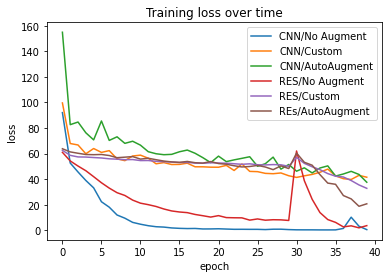

In [31]:
plt.plot(loss2)
plt.plot(loss1)
plt.plot(loss3)
plt.plot(loss4)
plt.plot(loss5)
plt.plot(loss6)
plt.title('Training loss over time')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['CNN/No Augment', 'CNN/Custom', 'CNN/AutoAugment', 'RES/No Augment', 'RES/Custom', 'REs/AutoAugment'])

Text(0, 0.5, 'loss')

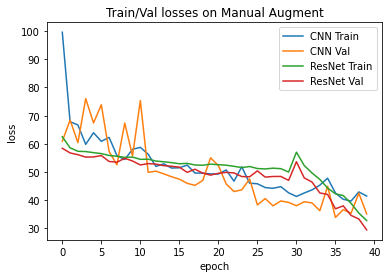

In [50]:
plt.plot(loss1)
plt.plot(val1)
plt.plot(loss5)
plt.plot(val5)
plt.legend(['CNN Train', 'CNN Val', 'ResNet Train', 'ResNet Val'])
plt.title('Train/Val losses on Manual Augment')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

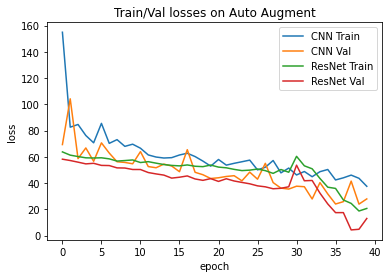

In [51]:
plt.plot(loss3)
plt.plot(val3)
plt.plot(loss6)
plt.plot(val6)
plt.legend(['CNN Train', 'CNN Val', 'ResNet Train', 'ResNet Val'])
plt.title('Train/Val losses on Auto Augment')
plt.xlabel('epoch')
plt.ylabel('loss')

In [36]:
batch_1 = next(iter(train_loader))

In [37]:
img = np.moveaxis(batch_1[0][2].numpy(), 0, -1)

(-0.5, 175.5, 207.5, -0.5)

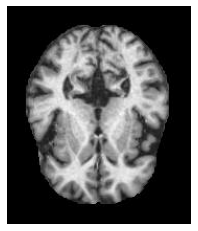

In [43]:
plt.imshow(img)
plt.axis('off')

In [39]:
autoimg = np.moveaxis(auto_augment(batch_1[0][2]).numpy(), 0, -1)

(-0.5, 175.5, 207.5, -0.5)

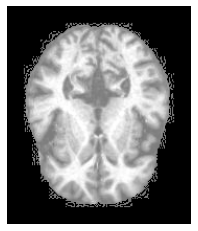

In [44]:
plt.imshow(autoimg)
plt.axis('off')

In [41]:
augimg = np.moveaxis(augmentations(batch_1[0][2]).numpy(), 0, -1)
x, y = np.random.randint(15,185), np.random.randint(20,150)
augimg[x:x+10,y:y+10,:] = 0

(-0.5, 175.5, 207.5, -0.5)

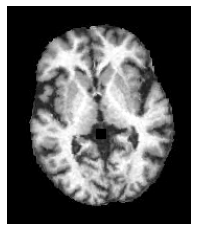

In [45]:
plt.imshow(augimg)
plt.axis('off')

In [46]:
augimg.shape

(208, 176, 3)